In [14]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp
import pingouin as pg

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

In [15]:
# FIND THE DATA WE NEED
subj = (subject.Subject() & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()
b = subj * session_with_date * avg_weight_date * total_water_date
df = pd.DataFrame(b.fetch(as_dict=True))
#df.tail(n=10)

weight_normalized = pd.DataFrame([])
for index, sjdat in df.groupby(['subject_nickname']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    weight_normalized = weight_normalized.append(sjdat)

df = weight_normalized.copy()
df['performance_easy'] = df.performance_easy * 100

# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                 27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W',
                 36:'H5', 37:'H2', 38:'C', 39:'H5'}
# condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
#                  17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
#                  27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W'}
# week 26: leaks in tube, don't use

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
# sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
# sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))

# redo the color mapping
condition_order = ["WW", "W", "O", "C", "CC", "H2", "H5"]
palette = sns.xkcd_palette(['deep blue', 'electric blue', 'azure', 'purpley pink', 'raspberry', 'lilac', 'dark lilac'])
marker_mapping = {'WW':'<', 'W':'>', 'O':'o', 'C':'v', 'CC':'^', 'H2':'P', 'H5':'X'}
condition_names = ['Free water', 'Free wknd water', 'Measured water', 
                   'Free wknd CA water', 'Free CA water', 'Wknd 2% CA Hydr', 'Wknd 5% CA Hydr']
print(sorted(df.subject_nickname.unique()))

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
031c2ecf-455f- human0023      U      
033e34f1-e352- human0200      U      
034c07c5-69b0- IBL_25         M      
04631e68-7bae- human0195      U      
05e81ab3-073f- human0104      U      
063bc242-80a7- IBL_16         M      
07212dba-e186- human0154      U      
08dea2d2-7340- human0184      U      
0ab57398-e556- human0111      U      
0cd801df-6043- human0084      U      
0e35242e-f1e1- human0151      U      
0e53219b-0f24- human0114      U      
   ...
 (Total: 223)

['IBL_1', 'IBL_10', 'IBL_11', 'IBL_13', 'IBL_34', 'IBL_46']


/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# SPLIT INTO DATASETS, SEPARATE FIGURE FIGURES 2 AND 3
df2 = df.loc[df.week_number < 35, :]
df3 = df.loc[df.week_number > 35, :]

In [17]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(40)
        item.set(ha='right')

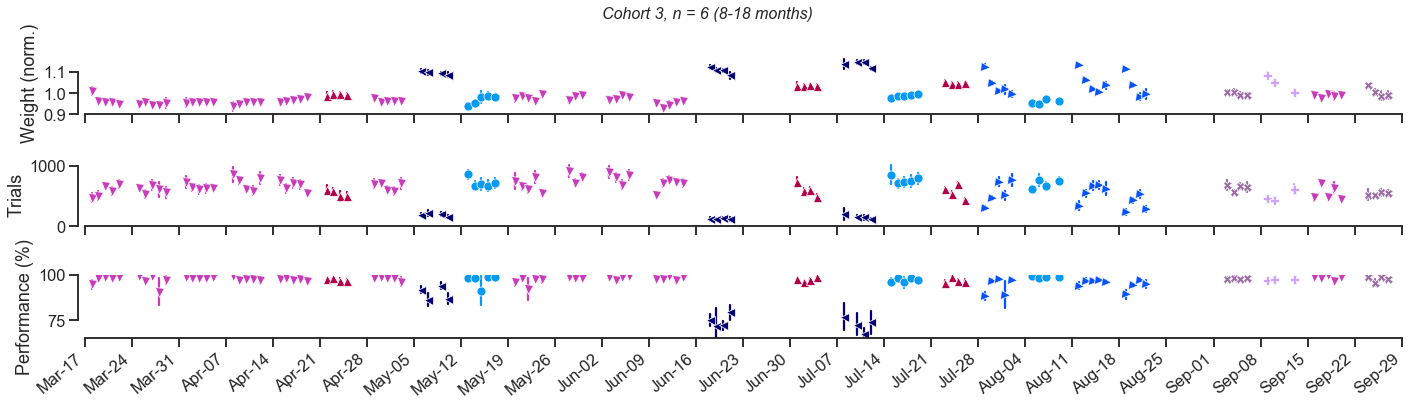

In [18]:
## NOW PLOT WITH SEABORN - supplementary figure, all the data over time
f, ax = plt.subplots(ncols=1, nrows=3, 
                     gridspec_kw=dict(height_ratios=[1,1,1]), figsize=(20, 6))
ylims_weight = [0.9, 1.2]
ylims_ntrials = [0, 1050]
ylims_performance = [65, 100]
xlims = [df.session_date.min()-timedelta(days=2), df.session_date.max()+timedelta(days=3)]

sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", 
             style='condition', markers=marker_mapping, dashes=False,
             linewidth=0, data=df, ax=ax[0], legend=False, hue_order=condition_order, palette=palette)
ax[0].set(ylabel="Weight (norm.)", ylim=ylims_weight, xlabel="", xlim=xlims)
ax[0].tick_params(labelbottom=False)    
#ax[0].text(df.session_date.min(), ylims_weight[1]*0.95, 'n = 6', {'color':'k', 'fontsize':16})
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", 
             style='condition', markers=marker_mapping, dashes=False,
             linewidth=0, data=df, ax=ax[1], legend=False, hue_order=condition_order, palette=palette)
ax[1].set(ylabel="Trials", xlabel="", ylim=ylims_ntrials, xlim=xlims)
ax[1].tick_params(labelbottom=False)    
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, 
             hue="condition",style='condition', markers=marker_mapping, dashes=False,
             linewidth=0, data=df, ax=ax[2], legend=False, hue_order=condition_order, palette=palette)
ax[2].set(ylabel="Performance (%)", xlabel="", ylim=ylims_performance, xlim=xlims)

# set grid to show Mondays
fix_date_axis(ax[0])
fix_date_axis(ax[1])
fix_date_axis(ax[2])

# SAVE
f.suptitle('Cohort 3, n = 6 (8-18 months)', fontsize=16, fontstyle='italic')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "citricacid_suppfig.pdf"))
f.savefig(os.path.join(figpath, "citricacid_suppfig.png"), dpi=400)

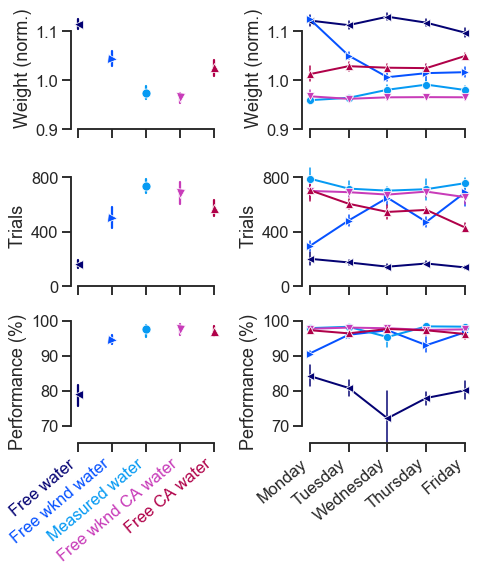

In [19]:
# remove hydrogel from this plot
ylims_ntrials = [0, 1000]
f, ax = plt.subplots(ncols=2, nrows=3, 
                     gridspec_kw=dict(width_ratios=[0.7, 0.8], height_ratios=[1,1,1]), figsize=(7,9))

ylims_weight = [0.9, 1.15]
ylims_ntrials = [0, 900]
ylims_performance = [65, 100]

## SECOND COLUMN
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition",
             linewidth=2, 
             data=df2.groupby(['subject_nickname', 'weekday', 'condition'])['avg_weight'].mean().reset_index(),
             ax=ax[0,1], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=8,
            err_kws={'elinewidth':1.5})
ax[0,1].set(ylabel="Weight (norm.)", ylim=ylims_weight, xlabel="")
ax[0,1].tick_params(labelbottom=False)   
ax[0,1].set_xticks(range(5))

sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df2.groupby(['subject_nickname', 'weekday', 'condition'])['n_trials'].mean().reset_index(),
             ax=ax[1,1], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=8,
            err_kws={'elinewidth':1.5})
ax[1,1].set(ylabel="Trials", ylim=ylims_ntrials, xlabel="")
ax[1,1].tick_params(labelbottom=False)    
ax[1,1].set_xticks(range(5))
ax[1,1].set_yticks([0,400,800])

sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df2.groupby(['subject_nickname', 'weekday', 'condition'])['performance_easy'].mean().reset_index(),
             ax=ax[2,1], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=8,
            err_kws={'elinewidth':1.5})
ax[2,1].set(ylabel="Performance (%)", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="", ylim=ylims_performance)

for item in ax[2,1].get_xticklabels():
    item.set_rotation(40)
    item.set(ha='right')
    
## Third columns
sns.lineplot(x="condition", y="avg_weight", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df2.groupby(['subject_nickname', 'condition'])['avg_weight'].mean().reset_index(),
             ax=ax[0,0])
ax[0,0].set(ylabel="Weight (norm.)", xlabel="", ylim=ylims_weight)
ax[0,0].get_legend().remove()
ax[0,0].tick_params(labelbottom=False)    
ax[0,0].set_xticks(range(5))

sns.lineplot(x="condition", y="n_trials", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df2.groupby(['subject_nickname', 'condition'])['n_trials'].mean().reset_index(),
             ax=ax[1,0])
#sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1,2], boxprops={'facecolor':'None'}, width=.3)
ax[1,0].set(ylabel="Trials", xlabel="", ylim=ylims_ntrials)
ax[1,0].get_legend().remove()
ax[1,0].tick_params(labelbottom=False)    
sns.lineplot(x="condition", y="performance_easy", err_style='bars', style='condition', markers=marker_mapping, 
             ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df2.groupby(['subject_nickname', 'condition'])['performance_easy'].mean().reset_index(),
             ax=ax[2,0])
ax[1,0].set_xticks(range(5))
ax[1,0].set_yticks([0,400,800])

#sns.lineplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2,2], boxprops={'facecolor':'None'}, width=.3)
ax[2,0].set(ylabel="Performance (%)", xlabel="", ylim=ylims_performance)
ax[2,0].get_legend().remove()
ax[2,0].set_xticklabels(condition_names)
ax[2,0].set_xticks(range(5))

# SAVE
sns.despine(trim=True)
#f.suptitle('Cohort 3, n = 6 (8-18 months)', fontsize=17, fontstyle='italic')
for ticklabel, tickcolor in zip(ax[2,0].get_xticklabels(), palette):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(40)
    ticklabel.set(ha='right')
    
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.savefig(os.path.join(figpath, "citricacid_study2.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2.png"), dpi=400)

In [8]:
#### simple t-test for trial counts between 1ml/day and CA weekend
statdat = df2.groupby(['subject_nickname', 'condition'])['n_trials'].mean().reset_index()
oneml = statdat.loc[statdat.condition == 'O', 'n_trials']
ca = statdat.loc[statdat.condition == 'C', 'n_trials']
statistic, pval = sp.stats.ttest_rel(oneml, ca)
print('weekend CA vs measured water: t(%d) = %.3f, p = %.4f'%(len(ca)-1, statistic, pval))
pg.ttest(oneml, ca, paired=True)


weekend CA vs measured water: t(5) = 0.880, p = 0.4193


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.88,5,two-sided,0.419349,"[-99.21, 202.42]",0.558,0.505,0.2


In [9]:
#### simple t-test for trial counts between weekend CA and full-week CA
statdat = df2.groupby(['subject_nickname', 'condition'])['n_trials'].mean().reset_index()
cc = statdat.loc[statdat.condition == 'CC', 'n_trials']
ca = statdat.loc[statdat.condition == 'C', 'n_trials']
statistic, pval = sp.stats.ttest_rel(cc, ca)
print('weekend CA vs week CA: mean %d vs %d, t(%d) = %.3f, p = %.4f'%(np.mean(ca), np.mean(cc), len(ca)-1, statistic, pval))
pg.ttest(cc, ca, paired=True)

weekend CA vs week CA: mean 682 vs 573, t(5) = -2.505, p = 0.0542


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.505,5,two-sided,0.054152,"[-220.49, 2.85]",1.141,1.971,0.613


In [11]:
#### simple t-test for trial counts between Monday and Friday in free Water  weekend
statdat = df2.loc[df2.condition == 'W', :].groupby(['subject_nickname', 'weekday'])['n_trials'].mean().reset_index()
one = statdat.loc[statdat.weekday == 0, 'n_trials']
two = statdat.loc[statdat.weekday == 4, 'n_trials']
statistic, pval = sp.stats.ttest_rel(one, two)
print('free weekend water, monday vs friday: t(%d) = %.3f, p = %.4f'%(len(ca)-1, statistic, pval))
pg.ttest(one, two, paired=True)


free weekend water, monday vs friday: t(5) = -3.951, p = 0.0108


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.951,5,two-sided,0.010845,"[-652.07, -137.99]",2.243,6.491,0.99


In [12]:
#### simple t-test for trial counts between Monday and Friday in free Water  weekend
statdat = df2.loc[df2.condition == 'CC', :].groupby(['subject_nickname', 'weekday'])['n_trials'].mean().reset_index()
one = statdat.loc[statdat.weekday == 0, 'n_trials']
two = statdat.loc[statdat.weekday == 4, 'n_trials']
statistic, pval = sp.stats.ttest_rel(one, two)
print('free CA, monday vs friday: t(%d) = %.3f, p = %.4f'%(len(ca)-1, statistic, pval))
pg.ttest(one, two, paired=True)


free CA, monday vs friday: t(5) = 3.002, p = 0.0300


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.002,5,two-sided,0.030042,"[39.53, 510.97]",1.9,3.035,0.956


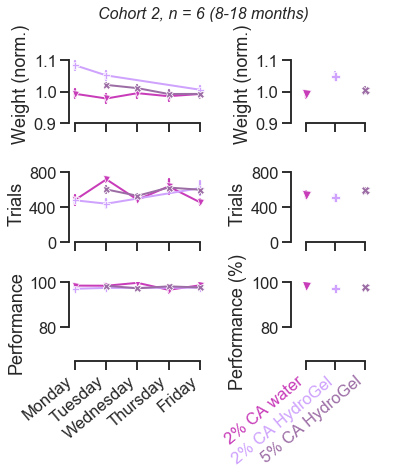

In [13]:
# NOW REPEAT, BUT ONLY WITH HYDROGEL + CA WEEKEND!!!
# ylims_weight = [0.9, 1.1]
# ylims_ntrials = [0, 800]
# ylims_performance = [65, 100]

f, ax = plt.subplots(ncols=2, nrows=3, 
                     gridspec_kw=dict(width_ratios=[1, 0.8], height_ratios=[1,1,1]), figsize=(6,7))

condition_names = ['2% CA water', '2% CA HydroGel', '5% CA HydroGel']
condition_order = ["C","H2", "H5"]
palette = sns.xkcd_palette(['purpley pink', 'lilac', 'dark lilac'])
marker_mapping = { 'C':'v',  'H2':'P', 'H5':'X'}

## SECOND COLUMN
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition",
             linewidth=2, 
             data=df3.groupby(['subject_nickname', 'weekday', 'condition'])['avg_weight'].mean().reset_index(),
             ax=ax[0,0], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=7)
ax[0,0].set(ylabel="Weight (norm.)", ylim=ylims_weight, xlabel="")
ax[0,0].tick_params(labelbottom=False)   
ax[0,0].set_xticks(range(5))
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df3.groupby(['subject_nickname', 'weekday', 'condition'])['n_trials'].mean().reset_index(),
             ax=ax[1,0], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=7)
ax[1,0].set(ylabel="Trials", ylim=ylims_ntrials, xlabel="", yticks=[0,400,800])
ax[1,0].tick_params(labelbottom=False)    
ax[1,0].set_xticks(range(5))

sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df3.groupby(['subject_nickname', 'weekday', 'condition'])['performance_easy'].mean().reset_index(),
             ax=ax[2,0], legend=False, hue_order=condition_order, palette=palette,
            style="condition", markers=marker_mapping, dashes=False, markersize=7)
ax[2,0].set(ylabel="Performance", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="", ylim=ylims_performance)
ax[2,0].set_xticks(range(5))

for item in ax[2,0].get_xticklabels():
    item.set_rotation(40)
    item.set(ha='right')
    
## Third columns
sns.lineplot(x="condition", y="avg_weight", err_style='bars', style='condition', markers=marker_mapping, 
             ci=68, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df3.groupby(['subject_nickname', 'condition'])['avg_weight'].mean().reset_index(),
             ax=ax[0,1])
#sns.boxplot(x="condition", y="avg_weight", order=condition_order,data=df, fliersize=0, ax=ax[0,2], boxprops={'facecolor':'None'}, width=.3)
ax[0,1].set(ylabel="Weight (norm.)", xlabel="", ylim=ylims_weight)
ax[0,1].get_legend().remove()
ax[0,1].tick_params(labelbottom=False)    
ax[0,1].set_xticks(range(3))
ax[0,1].set_xlim([-0.5, 3.2])

sns.lineplot(x="condition", y="n_trials", err_style='bars', style='condition', markers=marker_mapping, 
             ci=68, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df3.groupby(['subject_nickname', 'condition'])['n_trials'].mean().reset_index(),
             ax=ax[1,1])
#sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1,2], boxprops={'facecolor':'None'}, width=.3)
ax[1,1].set(ylabel="Trials", xlabel="", ylim=ylims_ntrials, yticks=[0,400,800])
ax[1,1].get_legend().remove()
ax[1,1].tick_params(labelbottom=False)   
ax[1,1].set_xticks(range(3))
ax[1,1].set_xlim([-0.5, 3.2])

sns.lineplot(x="condition", y="performance_easy", err_style='bars', style='condition', markers=marker_mapping, 
             ci=68, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", 
             data=df3.groupby(['subject_nickname', 'condition'])['performance_easy'].mean().reset_index(),
             ax=ax[2,1])
#sns.lineplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2,2], boxprops={'facecolor':'None'}, width=.3)
ax[2,1].set(ylabel="Performance (%)", xlabel="", ylim=ylims_performance)
ax[2,1].get_legend().remove()
ax[2,1].set_xticklabels(condition_names)
ax[2,1].set_xticks(range(3))
ax[2,1].set_xlim([-0.5, 3.2])

for ticklabel, tickcolor in zip(ax[2,1].get_xticklabels(), palette):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(40)
    ticklabel.set(ha='right')

# SAVE
f.suptitle('Cohort 2, n = 6 (8-18 months)', fontsize=16, fontstyle='italic')
sns.despine(trim=True)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.savefig(os.path.join(figpath, "citricacid_study3c.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study3c.png"), dpi=600)
